## Homework 1: Finding submarines
Cassia Cai <br> fmc2855@uw.edu

#### Goal: locate a submarine in the Puget Sound using noisy acoustic data

We do not know much about this submarine as it is a new technology that emits an unknown acoustic frequency that you need to detect. Unfortunately the submarine is moving so its location and path need to be determined.

Broad spectrum recording of acoustics data obtained over 24 hours in half-hour increments is available to you. The data file contain a matrix with 49 columns of data corresponding to the measurements of acoustic pressure taken over 24 hours. The measurements themselves are 3D and taken on a uniform grid of size 64 × 64 × 64. The provided notebook will visualize this data for you. 

Tasks:
1. Through averaging of the Fourier transform and visual inspection, determine the frequency signature (center frequency) generated by the submarine.
2. Design and implement a Filter to extract this frequency signature in order to denoise the data and determine the path of the submarine. You can also plot the 3D path of the submarine if you like.
3. Determine and plot the 𝑥, 𝑦 coordinates of the submarine during the 24 hour period. This information can be used to deploy a sub-tracking aircraft to keep an eye on your submarine in the future.

In [85]:
#  ------------------ import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from matplotlib.colors import LogNorm
import scipy 
from scipy import ndimage

In [86]:
# ------------------ load acoustic data
data_path = 'subdata.npy'

d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)

In [266]:
# ------------------ from helper code
L = 10; # length of spatial domain (cube of side L = 2*10)
N_grid = 64; # number of grid points/Fourier modes in each direction

# K_grid = (2*np.pi/(2*L))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid) # frequency grid for one coordinate
k_grid = np.linspace(-N_grid/2, N_grid/2 - 1, N_grid)

# k1, k2 = np.meshgrid(K_grid, K_grid)
# k1, k2 = np.meshgrid(k_grid, k_grid)

In [353]:
# ------------------ compute fft of the original signal and locate the center frequency of the submarine
fft = np.ndarray((64,64,64,49))
len_time = 49

for t in np.arange(len_time):
    signal = np.reshape(d[:, t], (N_grid, N_grid, N_grid))
    fft[:,:,:,t] = abs(np.fft.fftshift(np.fft.fftn(signal)))# .real why is it different if I put real here

signal_normalized = np.abs(signal)/np.abs(signal).max()

# Locate the center frequency of the sub
fft_ave = np.sum(fft, axis=3) / len_time
max_indices = np.unravel_index(np.argmax(fft_ave, axis = None), fft_ave.shape)
print(max_indices)
print(np.max(fft_ave))

(39, 49, 11)
136.54325262153827


In [354]:
z_level = max_indices[2] # from max_indices

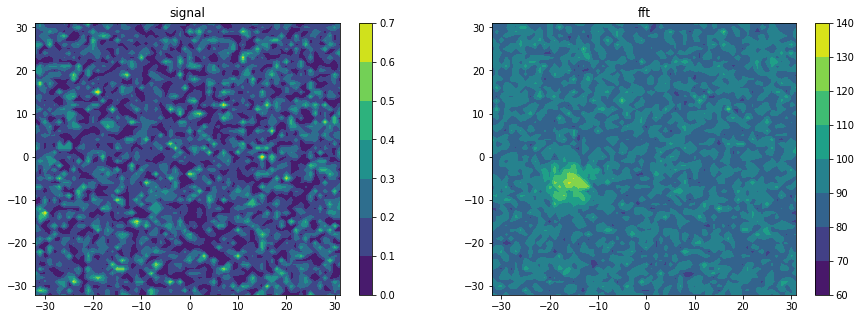

In [355]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1, 2, 1); plt.title('signal')
plt.contourf(k1, k2, np.abs(signal_normalized[:,:,55])); plt.colorbar()
plt.subplot(1, 2, 2); plt.title('fft')
plt.contourf(k1, k2, np.abs(fft_ave[:,:,55])); plt.colorbar()
# plt.scatter(k_grid[max_indices[1]],k_grid[max_indices[0]], s=50, c='red')
plt.show()

In [375]:
k_grid[max_indices[0]]

7.0

In [402]:
# ------------------------------------ a 3D Gaussian filter
def g_centered(x, y, z, s):
    centered_x2 = x - max_indices[1] + 32
    centered_y2 = y - max_indices[0] + 32
    centered_z2 = z - max_indices[2] + 32
    s_squared = s**2
    val = np.exp(-((centered_x2**2 + centered_y2**2 + centered_z2**2)/(2*s_squared)))
    return val

# ------------------ using the Gaussian filter
sigma = 20 # arbitrary at the moment
kz3, ky3, kx3 = np.meshgrid(k_grid, k_grid, k_grid)

# frequency in fourier space is kx, ky, and kz
x_posit = []
y_posit = []
z_posit = []

denoised = np.ndarray((64,64,64,49))
submarine_position = []
for t in np.arange(49):
    signal = np.reshape(d[:, t], (N_grid, N_grid, N_grid))
    fft = np.fft.fftshift(np.fft.fftn(signal))
    g_vals = g_centered(kx3, ky3, kz3, sigma)
    fft_filtered = fft * g_vals
    
    denoised_temp = np.real(np.fft.ifftn(np.fft.ifftshift(fft_filtered)))
    denoised_temp_normalized = np.abs(denoised_temp)/np.abs(denoised_temp).max()
    
    max_pos = np.unravel_index(denoised_temp_normalized.argmax(), denoised_temp_normalized.shape)
    submarine_position.append(max_pos)
    x_posit.append(max_pos[0])
    y_posit.append(max_pos[1])
    z_posit.append(max_pos[2])
    
    denoised[:,:,:,t] = denoised_temp

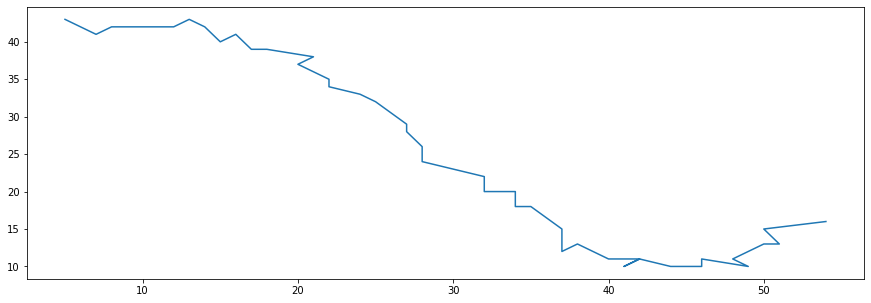

In [403]:
plt.plot(x_posit,y_posit)
plt.show()

In [ ]:
# ------------------------------------ a 3D coefficient filter

In [ ]:
# ------------------------------------ scipy.ndimage Gaussian filter

In [ ]:
# ------------------------------------ spherical filter

In [ ]:
# ------------------------------------ cubic filter

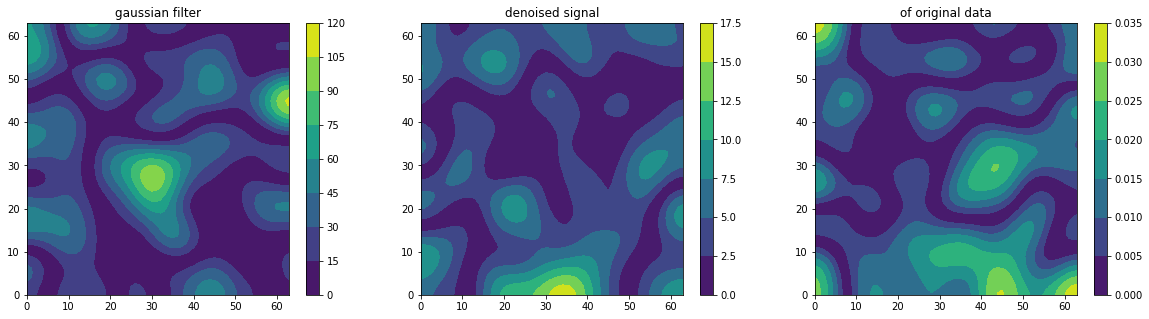

In [ ]:
signal = ifftn_d_reshaped
denoised_signal = np.fft.ifft(signal)

plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(1, 3, 1); plt.title('gaussian filter')
im_blur = ndimage.gaussian_filter(signal[:, :, z_lev, time_step].real, 5)
plt.contourf(abs(im_blur)); plt.colorbar()

plt.subplot(1, 3, 2); plt.title('denoised signal')
im_blur = ndimage.gaussian_filter(denoised_signal[:, :, z_lev, time_step].real, 5)
plt.contourf(abs(im_blur)); plt.colorbar()

plt.subplot(1, 3, 3); plt.title('of original data')
im_blur = ndimage.gaussian_filter(d_reshaped[:, :, z_lev, time_step].real, 5)
plt.contourf(abs(im_blur)); plt.colorbar(); plt.show()

In [180]:
# coefficient filtering of 64x64x64x49 cube
keep_fraction = 0.05 # Define the fraction of coefficients (in each direction) we keep

im_fftn = ifftn_d_reshaped.copy()
r, c, d, e = im_fftn.shape

# Set to zero all rows with indices between r*keep_fraction and r*(1-keep_fraction):
im_fftn[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
im_fftn[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
im_fftn[:, :, int(d*keep_fraction):int(d*(1-keep_fraction))] = 0
im_fftn[:, :, :, int(e*keep_fraction):int(e*(1-keep_fraction))] = 0